Dataset Description

Given a photo of an apple leaf, can you accurately assess its health? This competition will challenge you to distinguish between leaves which are healthy, those which are infected with apple rust, those that have apple scab, and those with more than one disease.

Files

#train.csv

image_id: the foreign key

combinations: one of the target labels

healthy: one of the target labels

rust: one of the target labels

scab: one of the target labels

#images

A folder containing the train and test images, in jpg format.

#test.csv

image_id: the foreign key

In [46]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [47]:
try:
    tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(device='GPU')
except:
    pass

In [165]:
df = pd.read_csv('data/train.csv')
df.head(8),df.shape

(  image_id  healthy  multiple_diseases  rust  scab
 0  Train_0        0                  0     0     1
 1  Train_1        0                  1     0     0
 2  Train_2        1                  0     0     0
 3  Train_3        0                  0     1     0
 4  Train_4        1                  0     0     0
 5  Train_5        1                  0     0     0
 6  Train_6        0                  1     0     0
 7  Train_7        0                  0     0     1,
 (1821, 5))

In [167]:
train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)

(1456, 5)
(365, 5)


In [243]:

train_df = df.copy()

In [244]:
# data labels - Target  
labels = train_df.loc[:,'healthy':].columns
print(labels)

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [245]:
# lets give labels as following to separate the images into different folder as per their labels
# 'health':0 , 'multiple_diseases':1, 'rust':2, 'scab':3

def label_encoder(df, labels):
    label_counter = 0
    df['label'] = 0
    for class_name in labels:
        df['label'] = df['label'] + df[class_name] * label_counter
        label_counter += 1
    return df

In [254]:
train_df = label_encoder(train_df,labels)
train_df


,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,3
1817,Train_1817,1,0,0,0,0
1818,Train_1818,1,0,0,0,0
1819,Train_1819,0,0,1,0,2


In [255]:
from re import search
def get_label_img(img):
    ''' function to fetch the label of the image'''
    if search("Train",img):
        img=img.split('.')[0]
        label = train_df.loc[train_df['image_id']==img]['label']
        return label

In [256]:

from tqdm import tqdm
MAIN_PATH = os.getcwd()
IMAGE_DIR = 'data/images/'
IMG_SIZE = 224

In [257]:
# lets separate the images into separate folders according to their labels
def create_dir_image_labels():
    # sort the filenames in IMAGE_DIR
    images = os.listdir(IMAGE_DIR)
    for img in tqdm(images):
        # function to fetch the label of the image
        label = get_label_img(img)
        # image path from the original image dir
        image_path = os.path.join(IMAGE_DIR,img)
        
        if search("Train",img):
            # if image label is equal to 0, copy that image into healthy directory.
            if (img.split("_")[1].split(".")[0]) and label.item()==0:
                shutil.copy(image_path, os.path.join(MAIN_PATH,'train','healthy'))
             
            # if image label is equal to 1, copy that image into multiple_diseases directory.
            elif(img.split("_")[1].split(".")[0]) and label.item()==1:
                shutil.copy(image_path,os.path.join(MAIN_PATH,'train','multiple_diseases'))
               
            # if image label is equal to 2, copy that image into rust directory.
            elif(img.split("_")[1].split(".")[0]) and label.item()==2:
                shutil.copy(image_path,os.path.join(MAIN_PATH,'train','rust'))
             
            # if image label is equal to 3, copy that image into scab directory.
            elif(img.split("_")[1].split(".")[0]) and label.item()==3:
                shutil.copy(image_path,os.path.join(MAIN_PATH,'train','scab'))
         
        # else copy all excluded images from the above conditions into test directory.
        elif search("Test",img):
            shutil.copy(image_path,'test')

In [252]:
# create directory for train - healthy, multiple_diseases, rust, scab and test images
shutil.os.mkdir(os.path.join(MAIN_PATH, 'train'))
shutil.os.mkdir(os.path.join(MAIN_PATH,'train','healthy'))
shutil.os.mkdir(os.path.join(MAIN_PATH,'train','multiple_diseases'))
shutil.os.mkdir(os.path.join(MAIN_PATH,'train','rust'))
shutil.os.mkdir(os.path.join(MAIN_PATH,'train','scab'))

shutil.os.mkdir(os.path.join(MAIN_PATH, 'test'))

In [258]:
create_dir_image_labels()

100%|██████████| 3642/3642 [00:24<00:00, 151.11it/s]


In [259]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing import image

In [260]:
# Batch Size
BATCH_SIZE = 16
# Epochs
EPOCHS = 50

In [261]:
# All images will be rescaled by 1.0/255
datagen=ImageDataGenerator(rescale=1.0/255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)

# Path - Train Directory 
Train_DIR = os.path.join(MAIN_PATH, 'train')

# Flow training images in batches of 16 using datagen generator
train_datagen=datagen.flow_from_directory(Train_DIR,
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         subset='training')

# Flow validation images in batches of 16 using datagen generator
val_datagen=datagen.flow_from_directory(Train_DIR,
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         subset='validation')

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


In [262]:
# Formation of CNN model

model=Sequential()
# Note the input shape is the desired size of the image 224x224 with 3 color
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
# Max Pooling Layer
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
# Flatten the results to feed into a DNN
model.add(Flatten())
# 4 output neuron because of 4 labels in output layer
model.add(Dense(4,activation='softmax'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [263]:
# Checkpoint to save the best model on the basis of validation loss
checkpoint=ModelCheckpoint('./best_weights.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
# Early Stop - if the number of epochs that is 10 without improvement of validation loss after which training will be early stopped.
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [264]:
history = model.fit(train_datagen,validation_data=val_datagen,
                    epochs=EPOCHS,
                    steps_per_epoch=train_datagen.samples//BATCH_SIZE,
                    validation_steps=val_datagen.samples//BATCH_SIZE,callbacks=callbacks)

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.3301
Epoch 1: val_loss improved from inf to 1.25793, saving model to .\best_weights.h5
91/91 [==============================] - 81s 731ms/step - loss: 1.2811 - accuracy: 0.3301 - val_loss: 1.2579 - val_accuracy: 0.2812
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.3502
Epoch 2: val_loss improved from 1.25793 to 1.24961, saving model to .\best_weights.h5
91/91 [==============================] - 55s 600ms/step - loss: 1.2522 - accuracy: 0.3502 - val_loss: 1.2496 - val_accuracy: 0.3409
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 1.1958 - accuracy: 0.4029
Epoch 3: val_loss improved from 1.24961 to 1.07124, saving model to .\best_weights.h5
91/91 [==============================] - 55s 604ms/step - loss: 1.1958 - accuracy: 0.4029 - val_loss: 1.0712 - val_accuracy: 0.5710
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 

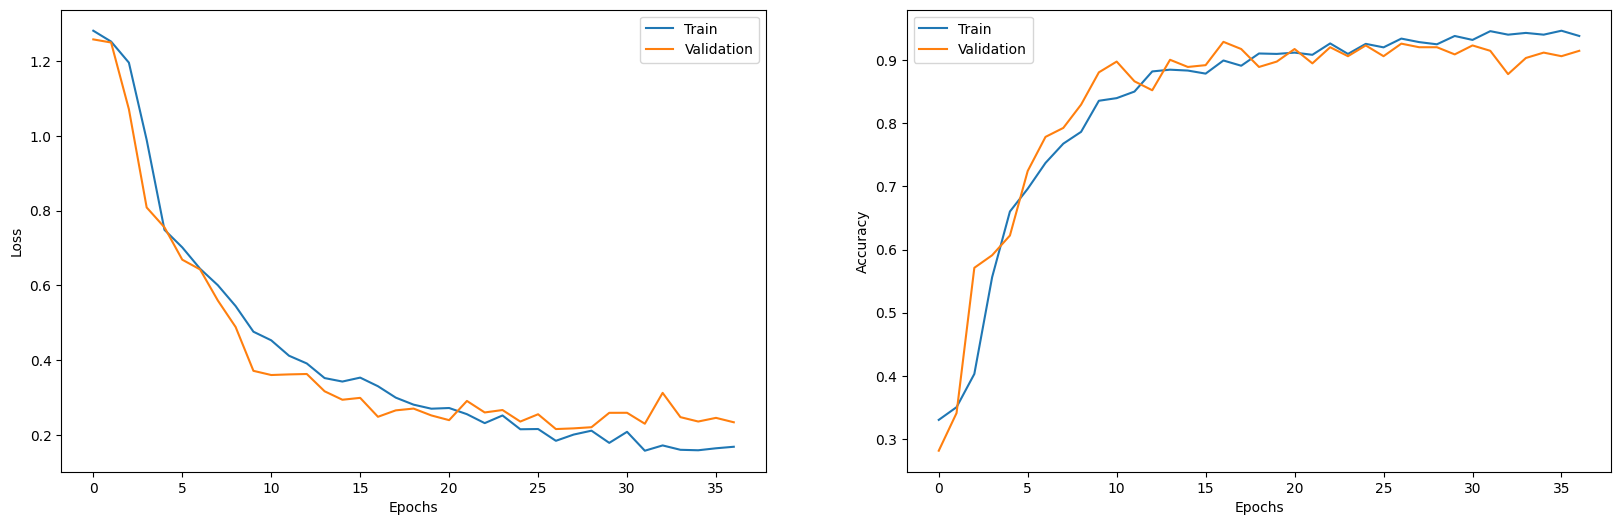

In [265]:
plt.figure(1, figsize = (20, 6))

plt.subplot(121)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()